# **Diabetic Retinopathy Classification**

The aim of this project is to classify retina images into different types of Diabetic Retinopathy using deep learning



#### 0. Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

from utils.visualizations import normalize_image, plot_class_distribution, plot_images, plot_transformations
from utils.dataprocessing import split_dataset, get_dataset_mean_std
from utils.engine import calculate_topk_accuracy, train, evaluate, epoch_time

#### Place seed

This step will allow reproducible results

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### 1. Split dataset 

We split the dataset in two directories: train and test, using the split_dataset function

In [3]:
TRAIN_RATIO = 0.8

images_dir = os.path.join('archive')
train_dir = os.path.join(images_dir, 'train')
test_dir = os.path.join(images_dir, 'test')

split_dataset(images_dir, train_dir, test_dir, TRAIN_RATIO, SEED)


#### 2. Data exploration and pre-processing

In the following cells, we will explore the dataset distribution and pre-process images before inputing them into the model.

**2.1** Get the dataset mean and standard deviation to further normalize images

In [ ]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means, stds = get_dataset_mean_std(train_data)

KeyboardInterrupt: 

**2.2** Build the transforms pipeline of the train and test set

In [4]:
pretrained_size = 224
pretrained_means = [0.3204, 0.2244, 0.1613]
pretrained_stds= [0.2620, 0.1831, 0.1320]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

**2.3** Instantiate train and test datasets classes

In [5]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)
                                 

**2.4** We create a validation subset from the training set to further validate model training

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25289
Number of validation examples: 2810
Number of testing examples: 7027


**2.5** Instantiation of dataloaders

In [9]:
BATCH_SIZE = 500

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = 50)

**2.6** Data Visualization

25 examples from the train split of the dataset with their corresponding class

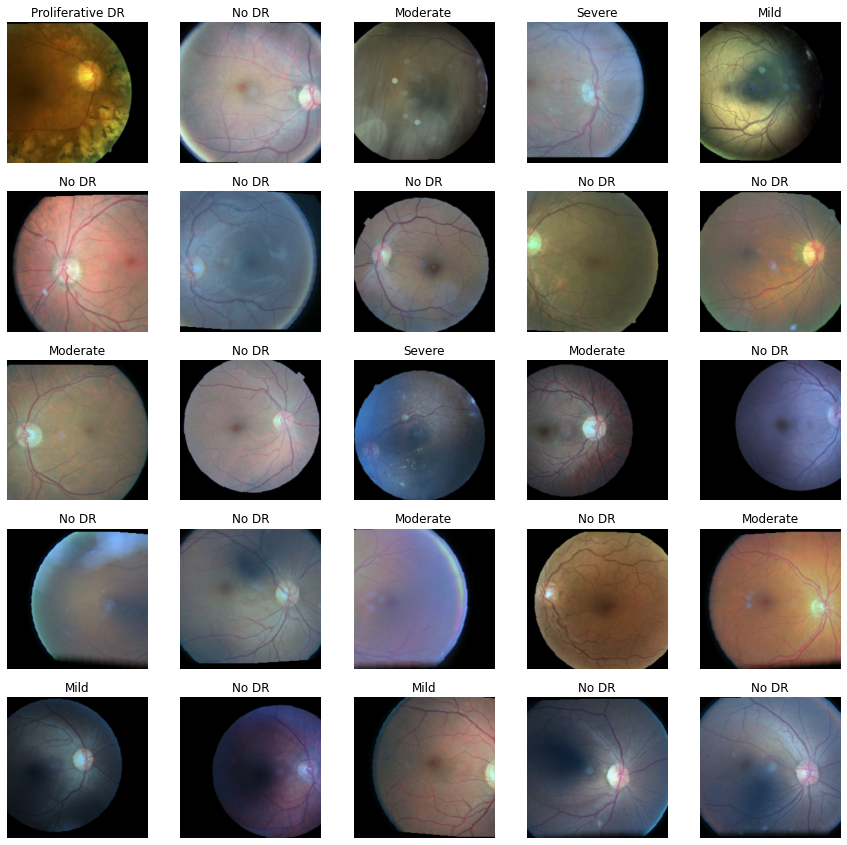

In [16]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

**2.7** Data Exploration

The class distribution of the train split. It can be noticed that the data is highly imbalanced, which is common in a medical dataset

In [44]:
plot_class_distribution(train_data, classes)

KeyboardInterrupt: 

**2.8** Data Pre-Processing

Data preprocessing consists of rezising and applying data augmentation techniques, such as rotation, horizontal flip and random crop. This will increase the number of examples during training and reduce overfitting

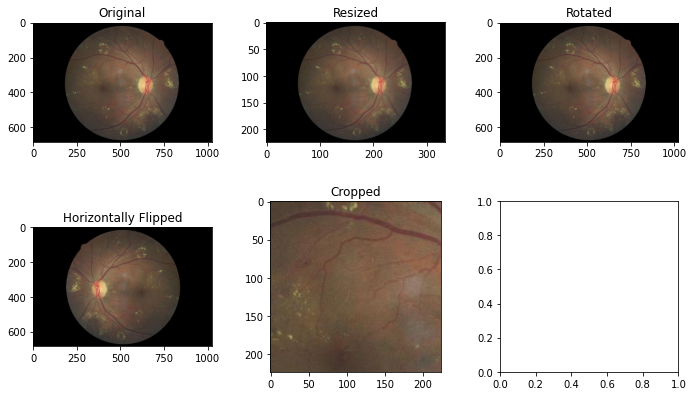

In [13]:
data_example = datasets.ImageFolder(root = train_dir,
                                    transform= transforms.ToTensor())

idx = np.random.randint(len(data_example))
image, label = data_example[idx]

plot_transformations(image, pretrained_size, pretrained_means, pretrained_stds)

In [11]:
model = models.resnet50(pretrained = True)

IN_FEATURES = model.fc.in_features 
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

model.fc = fc

In [12]:
START_LR = 1e-5

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [13]:
from torch.optim.lr_scheduler import StepLR

EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [14]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'retinopathy-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')